In [15]:
### Author: Alexander Davydov
# This notebook regenerates the example in Section V.B

import numpy as np
import cvxpy as cp
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from matplotlib import rc

## Inequality-constrained optimization problem
# Define the variables and constants
n = 2 # number of variables

def find_min_ineq(rt,Aineq, b):
    x = cp.Variable(2)
    objective = cp.Minimize(cp.norm((x+rt))**2 )
    constraints = [Aineq @ x <= b]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return x.value, constraints[0].dual_value

# Proximal operator on inequality constraint
def prox_ineq(x, b):
    return np.minimum(b, x)

# Gradient of the Moreau envelope for the inequality constraint
def moreau_grad(x, gamma, b):
    return 1/gamma*(x - prox_ineq(x, b))

# Dynamics
def f(x,theta1,theta2,gamma):
    f1 = -x[0] - theta1 + 1/gamma*np.maximum(-x[0] + x[1] + gamma*x[2] - theta2, 0)
    f2 = -x[1] - theta2 - 1/gamma*np.maximum(-x[0] + x[1] + gamma*x[2] - theta2, 0)
    f3 = -gamma*x[2] + np.maximum(-x[0] + x[1] + gamma*x[2] - theta2, 0)
    return np.array([f1, f2, f3])

# Derivative of ReLU
def drelu(x):
    if x <= 0:
        return 0
    else:
        return 1

# Jacobian matrix
def df(x,theta1,theta2,gamma):
    xbar = -x[0] + x[1] + gamma*x[2] - theta2
    return np.array([[-1 - 1/gamma*drelu(xbar), 1/gamma*drelu(xbar), drelu(xbar)],
                    [1/gamma*drelu(xbar), -1-1/gamma*drelu(xbar), -drelu(xbar)],
                    [-drelu(xbar), drelu(xbar), -gamma + gamma*drelu(xbar)]])
    
# Nonsmooth Newton method for finding the time-varying equilibrium point
def newton(f, df, x0, theta1, theta2, gamma, tol=1e-4, maxiter=30):
    x = np.copy(x0)
    for i in range(maxiter):
        f_val = f(x,theta1,theta2,gamma)
        if np.max(np.abs(f_val)) < tol:
            break
        df_val = df(x,theta1,theta2,gamma)
        dx = np.linalg.solve(df_val, -f_val)
        x += dx
    return x

# Find contraction weight
def find_weight_ineq(jac1, jac2, alpha):
    P = cp.Variable((3,3), symmetric=True)
    objective = cp.Minimize(0)
    constraints = [P @ jac1 + jac1.T @ P << 2*alpha*P,
                   P @ jac2 + jac2.T @ P << 2*alpha*P,
                  P >> 0.5*np.eye(3),
                  P << 50*np.eye(3)]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    stat = prob.status
    if stat == "optimal":
        return P.value
    else:
        return np.array([0])

# Bisection algorithm for optimal contraction rate
def bisection_P(jac1,jac2, lower, upper):
    while(upper - lower > 0.02):
        guess = 0.5*(upper + lower)
        P = find_weight_ineq(jac1,jac2,guess)
        if P.all() == 0:
            lower = guess
        else:
            upper = guess
    return find_weight_ineq(jac1,jac2,upper), upper

In [10]:
n = 2
w = 0.2
mu = w
T = 4500
gamma = 10

# Time-varying parameters
r = lambda t: np.array([np.sin(w*t), np.cos(w*t)])
# Objective function
obj = lambda x, t: 0.5 * np.linalg.norm((x + r(t).flatten()))**2 
# Gradient of objective function
obj_grad = lambda x, t: (x + r(t).flatten())

# Matrix and vector defining the inequality constraint
Aineq = lambda t: np.array([-1, 1])
b2 = lambda t: np.cos(w*t)

dt = 0.01
xins = np.zeros((n, T))
xinopts = np.zeros((n,T))
laminopts = np.zeros((1,T))
lamins = np.zeros((1,T))
tins = np.zeros((1,T))
weightnormins = np.zeros((1,T))
zinopts = np.zeros((n+1,T))

xinopts[:,0], laminopts[:,0] = find_min_ineq(r(0),Aineq(0),b2(0))
zinopts[:,0] = np.squeeze(newton(f,df, np.zeros((3,1)), np.sin(0), np.cos(0), gamma))

for i in range(T-1):
    # Euler integrate dynamics
    tc = tins[:,i]
    xc = xins[:, i]
    lamc = lamins[:,i]
    tc = np.squeeze(tc)
    xk = xc - dt*(obj_grad(xc, tc) + Aineq(tc) * moreau_grad(np.inner(Aineq(tc), xc) + gamma* lamc, gamma, b2(tc)))
    lamk = lamc + dt*gamma*(-lamc + moreau_grad(np.inner(Aineq(tc), xc) + gamma* lamc, gamma, b2(tc)))
    xins[:,i+1] = xk
    lamins[:,i+1] = lamk
    tins[:,i+1] = tc + dt
    xinopts[:,i+1], laminopts[:,i+1] = find_min_ineq(r(tc).flatten(),Aineq(tc),b2(tc))
    # Time-varying equilibrium point is computed by Newton method
    zinopts[:,i+1] = np.squeeze(newton(f,df, np.zeros((3,1)), np.sin(w*tc), np.cos(w*tc), gamma))
    
print(np.linalg.norm(xins[:,-1]-xinopts[:,-1]))

0.1917196161150836


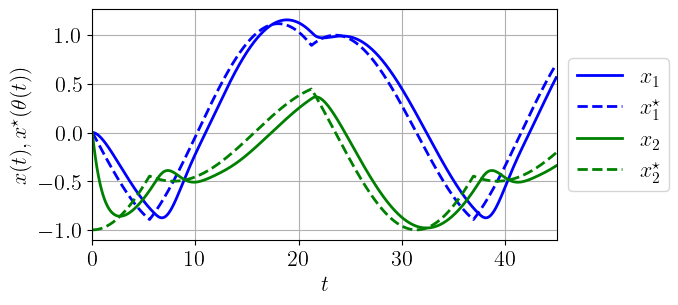

In [11]:
plt.rcParams.update({'font.size': 16})
rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(6, 3))

ax.grid()
ax.plot(tins.T, xins[0,:].T, 'b', linewidth=2, label=r'$x_1$')
ax.plot(tins.T,xinopts[0,:].T, 'b--', linewidth=2, label=r'$x_1^{\star}$')
ax.plot(tins.T, xins[1,:].T, 'g', linewidth=2, label=r'$x_2$')
ax.plot(tins.T,xinopts[1,:].T, 'g--', linewidth=2, label=r'$x_2^{\star}$')
plt.xlim(0, 45.1)

plt.xlabel(r'$t$')
plt.ylabel(r'$x(t), x^{\star}(\theta(t))$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

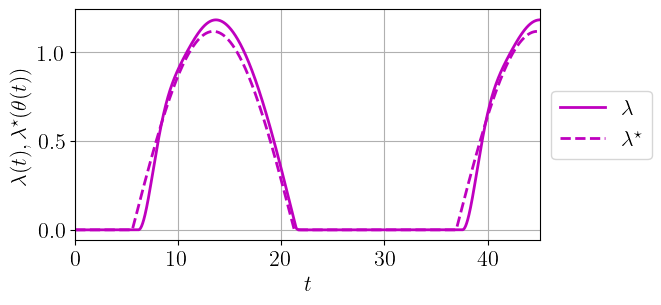

In [13]:
laminopts = zinopts[2,:]

fig, ax = plt.subplots(figsize=(6, 3))

ax.grid()
ax.plot(tins.T, lamins[0,:].T, 'm', linewidth=2, label=r'$\lambda$')
ax.plot(tins.T,laminopts[:].T, 'm--', linewidth=2, label=r'$\lambda^{\star}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 45.1)

plt.xlabel(r'$t$')
plt.ylabel(r'$\lambda(t), \lambda^{\star}(\theta(t))$')
plt.show()

norm with respect to which we are contracting: [[ 0.49791399 -0.21378238 -0.203193  ]
 [-0.21378238  0.49791399  0.203193  ]
 [-0.203193    0.203193    0.71358395]]
contraction rate: -0.5625
Lipschitz estimate: 1.2348832366519717
upper bound estimate: 0.7805681693405057


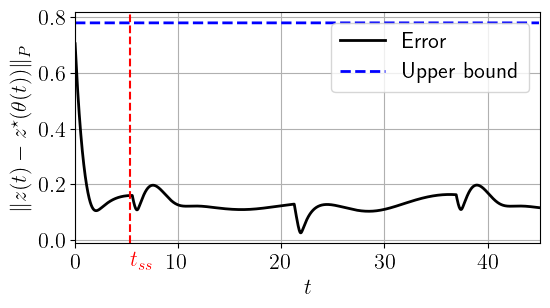

In [18]:
jac1 = np.array([[-1 - 1/gamma, 1/gamma, 1], [1/gamma, -1 - 1/gamma, -1], [-1, 1, 0]])
jac2 = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, -gamma]])

P, c = bisection_P(jac1,jac2, -2, 0)
val, vec = np.linalg.eig(P)
P = P/np.max(val)
print('norm with respect to which we are contracting:', P)
print('contraction rate:', c)

Phalf_ineq = sqrtm(P)

zins = np.vstack((xins,lamins))
errins = zins - zinopts

for i in range(len(errins[0,:])):
    erri = np.array([errins[:,i]])
    weightnormins[:,i] = np.sqrt(erri @ P @ erri.T)

jactheta1 = np.array([[-1, -1/gamma], [0, -1 + 1/gamma], [0, -1]])
jactheta2 = np.array([[-1, 0], [0, -1], [0, 0]])
# Lipschitz estimate
liptheta = np.max(np.array([np.linalg.norm(Phalf_ineq @ jactheta1, 2), np.linalg.norm(Phalf_ineq @ jactheta2, 2)]))
print('Lipschitz estimate:', liptheta)
uub_ineq = w*liptheta/(c**2)
print('upper bound estimate:', uub_ineq)
tss = -3/c

fig, ax = plt.subplots(figsize=(6, 3))

ax.grid()
ax.plot(tins.T, weightnormins[:].T, 'k', linewidth=2, label='Error')
ax.plot(tins.T, np.ones(T)*uub_ineq, 'b--', linewidth=2, label='Upper bound')
ax.axvline(x=tss, color='red', linestyle='--')
ax.text(tss, -0.095, r'$t_{ss}$', color='red', fontsize=16)
plt.legend()
plt.xlim(0, 45.1)

plt.xlabel(r'$t$')
plt.ylabel(r'$\|z(t) - z^{\star}(\theta(t))\|_{P}$')
plt.show()